<a href="https://colab.research.google.com/github/Aurorcys/VWAP-STRATEGY-BOT/blob/main/VWAP_BOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What Stock Would You Like? AAPL


/tmp/ipython-input-608954675.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, period=period)
[*********************100%***********************]  1 of 1 completed


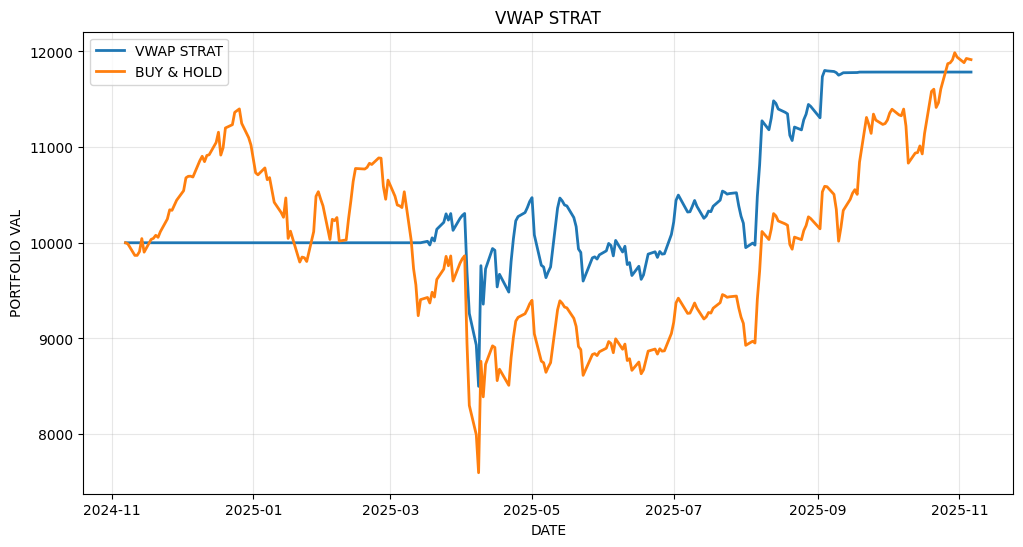

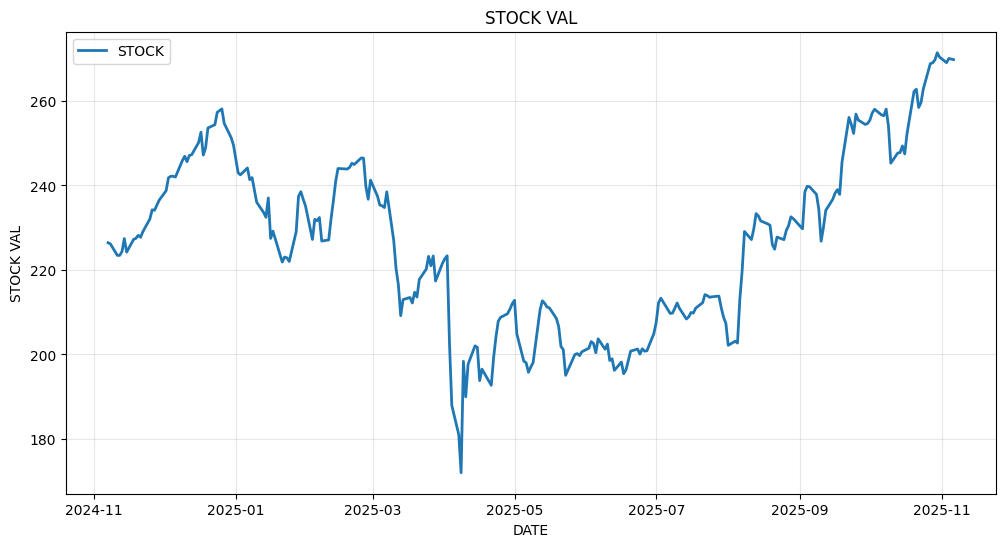

Last 20 Trades:
BOUGHT 18.321162940180383 AT 187.92002868652344 SPENDING 3442.9134652891676
BOUGHT 0.8941344513442314 AT 197.66615295410156 SPENDING 176.74011722094053
BOUGHT 0.34353922661735625 AT 192.68833923339844 SPENDING 66.19600303842448
BOUGHT 0.09765714267693483 AT 198.40435791015625 SPENDING 19.375602688157773
BOUGHT 0.031573895119265394 AT 208.54331970214844 SPENDING 6.584524904099067
BOUGHT 0.013434980364533125 AT 199.98304748535156 SPENDING 2.686768316205194
BOUGHT 0.0023608055215879786 AT 203.03956604003906 SPENDING 0.47933692860815125
BOUGHT 0.0005615711897091123 AT 202.44024658203125 SPENDING 0.11368461011807734
BOUGHT 9.039899140299239e-05 AT 195.418212890625 SPENDING 0.017665609347087746
BOUGHT 8.230801462713098e-07 AT 201.33151245117188 SPENDING 0.00016571197071733458
BOUGHT 1.2672510250785101e-08 AT 207.33470153808594 SPENDING 2.6274511305848633e-06
SOLD 45.748934609249204 AT 239.69000244140625 GAINING 10965.562248182676
SOLD 2.871465886579771 AT 234.07000732421875 G

In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def download(stock, period='1y'):
  data = yf.download(stock, period=period)
  if isinstance(data.columns, pd.MultiIndex):
      data.columns = data.columns.droplevel(1)
  return data

def calcVWAP(data):
  data['TypicalPrice'] = (data['High'] + data['Close'] + data['Low']) / 3

  data['VolumeT'] = data['TypicalPrice'].values * data['Volume'].values

  data['VWAP'] = data['VolumeT'].cumsum() / data['Volume'].cumsum()

  data['VWAPDIST'] = (data['Close'] - data['VWAP']) / data['VWAP'] * 100 #confindence rating instead of just 1 or -1

  data['VWAPSIGSTR'] = np.tanh(data['VWAPDIST'] / 2) #squishes the number between 1 and -1 to make it easier to compare
  #check usual data volatility for the stock

  data['VWAP_ZSCORE'] = data['VWAPDIST'] / data['VWAPDIST'].rolling(20).std() # this compares the usual VWAPDIST to today HIGH Z means overextension and likely pully back

  data['VWAP_CONFI'] = 100 * (1 - np.exp(-np.abs(data['VWAP_ZSCORE']) / 2)) #this gives a confidence rating score, making it easier to visualize the real meainig behind moves in the market

  return data

data = download(input('What Stock Would You Like? '))
data = calcVWAP(data)


cash = 10000
shares = 0
trades = []
portfolio = []

for i in range(len(data)):
  currentclose = data['Close'].iloc[i]
  if pd.isna(data['VWAP_ZSCORE'].iloc[i]):
    portfolio.append(cash + (shares * data['Close'].iloc[i]))
    continue
  if i % 5 == 0:
    Vscore = data['VWAP_ZSCORE'].iloc[i]
    Confidence = data['VWAP_CONFI'].iloc[i]
    if Vscore < -1.9 and cash > 0:
      risk = Confidence / 100
      sharestobuy = risk*cash / currentclose
      shares += sharestobuy
      trades.append(f'BOUGHT {sharestobuy} AT {currentclose} SPENDING {risk*cash}')
      cash -= risk*cash
    elif shares > 0 and Vscore > 1.7:
      sellrisk = min(1.0, Confidence / 100)
      sharestosell = shares*sellrisk
      shares -= sharestosell
      cashgain = sharestosell * currentclose
      cash += cashgain
      trades.append(f'SOLD {sharestosell} AT {currentclose} GAINING {cashgain}')
  if shares > 0:
    currentport = shares*currentclose + cash
  else:
    currentport = cash
  portfolio.append(currentport)


cashb = 10000
sharesb = 0
portfoliob = []

for i in range(len(data)):
  currentclose = data['Close'].iloc[i]
  if i == 0:
    sharesb = cashb / currentclose
    cashb = 0
  currentb = sharesb * currentclose
  portfoliob.append(currentb)



plt.figure(figsize=(12, 6))
plt.plot(data.index, portfolio, label='VWAP STRAT', linewidth=2)
plt.plot(data.index, portfoliob, label='BUY & HOLD', linewidth=2)
plt.title('VWAP STRAT')
plt.ylabel('PORTFOLIO VAL')
plt.xlabel('DATE')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='STOCK', linewidth=2)
plt.title('STOCK VAL')
plt.ylabel('STOCK VAL')
plt.xlabel('DATE')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()

print("Last 20 Trades:\n" + "\n".join(trades[-20:]))


